# Descarga y preparación del entorno

## Instalación de dependencias

In [ ]:
! pip install -r requirements.txt   

## Descomprimir datos
En el repositorio se incluye un archivo comprimido con los datasets en formato `.csv` de los créditos presupuestarios utilizados en el trabajo.

Estos fueron descargados el 5/10/2024 de la página de [presupuesto abierto](https://www.presupuestoabierto.gob.ar/sici/datos-abiertos) del gobierno nacional argentino. Los archivos utilizados se encuentran en la página como "Presupuesto de gastos y su ejecución detallada - agrupación anual".

También se incluye un script de python para descargar todos los datasets de este tipo disponibles al momento (desde 1995 hasta 2024). Se puede encontrar en `utils/descarga-presupuestos.py`.

In [ ]:
import zipfile
import os

# Cambiar al directorio "credito-anual"
os.chdir('data/presupuesto')

# Descomprimir el archivo "credito-anual.zip"
with zipfile.ZipFile('credito-anual.zip', 'r') as zip_ref:
    zip_ref.extractall()

os.chdir('../../')

print('Descomprimido credito-anual.zip')

# Manejo de los datos con Pandas

## Carga de .csv a DataFrames de Pandas

In [3]:
import pandas as pd
DFs = {}
for año in range(2012, 2020):
    df = pd.read_csv(f'data/presupuesto/credito-anual-{año}.csv', decimal=',')
    df.nombre = f'{año}'
    DFs[año] = df

## Funciones para el procesamiento de datos

In [4]:
def generar_dataframe_periodo(DFs, año_comienzo, año_fin):
    df = pd.concat([DFs[año] for año in range(
        año_comienzo, año_fin + 1)], ignore_index=True)
    df.nombre = f'{año_comienzo}-{año_fin}'
    return df


def calcular_total_pagado(df):
    return df['credito_pagado'].sum()


def calcular_total_pagado_por_funcion(df, funcion):
    return df[df['funcion_desc'].str.contains(funcion, na=False)]['credito_pagado'].sum()


def imprimir_resultados(df, total_pagado, total_pagado_trabajo, porcentaje):
    print(f'{df.nombre}:')
    print(f'    Total pagado: {total_pagado:,.2f}')
    print(f'    Total pagado con función \'Trabajo\': {
          total_pagado_trabajo:,.2f}')
    print(f'    Porcentaje pagado con función \'Trabajo\': {porcentaje}%')

## Calculo de inversión con función 'Trabajo' por períodos estudiados

In [5]:
periodos = {}
porcentaje_por_periodo = {}

for periodo in ['2012-2015', '2016-2019', '2012-2019']:
    start_year, end_year = periodo.split('-')
    periodos[periodo] = generar_dataframe_periodo(
        DFs, int(start_year), int(end_year))

    total_pagado = calcular_total_pagado(periodos[periodo])
    total_pagado_trabajo = calcular_total_pagado_por_funcion(
        periodos[periodo], 'Trabajo')
    porcentaje_por_periodo[periodo] = round(
        (total_pagado_trabajo/total_pagado)*100, 2)

    imprimir_resultados(periodos[periodo], total_pagado,
                        total_pagado_trabajo, porcentaje_por_periodo[periodo])

2012-2015:
    Total pagado: 3,673,561.01
    Total pagado con función 'Trabajo': 17,070.08
    Porcentaje pagado con función 'Trabajo': 0.46%
2016-2019:
    Total pagado: 12,317,476.66
    Total pagado con función 'Trabajo': 33,300.60
    Porcentaje pagado con función 'Trabajo': 0.27%
2012-2019:
    Total pagado: 15,991,037.68
    Total pagado con función 'Trabajo': 50,370.68
    Porcentaje pagado con función 'Trabajo': 0.31%


## Calculo de inversión con funcion 'Trabajo' por año

In [6]:
porcentaje_por_año = {}

for año in range(2012, 2020):
    total_pagado = calcular_total_pagado(DFs[año])
    total_trabajo = calcular_total_pagado_por_funcion(DFs[año], 'Trabajo')
    porcentaje_por_año[año] = round((total_trabajo/total_pagado)*100, 2)

    imprimir_resultados(DFs[año], total_pagado,
                        total_trabajo, porcentaje_por_año[año])

2012:
    Total pagado: 531,870.32
    Total pagado con función 'Trabajo': 3,106.80
    Porcentaje pagado con función 'Trabajo': 0.58%
2013:
    Total pagado: 701,981.01
    Total pagado con función 'Trabajo': 3,507.28
    Porcentaje pagado con función 'Trabajo': 0.5%
2014:
    Total pagado: 1,081,679.25
    Total pagado con función 'Trabajo': 4,211.20
    Porcentaje pagado con función 'Trabajo': 0.39%
2015:
    Total pagado: 1,358,030.44
    Total pagado con función 'Trabajo': 6,244.80
    Porcentaje pagado con función 'Trabajo': 0.46%
2016:
    Total pagado: 2,054,865.50
    Total pagado con función 'Trabajo': 6,358.43
    Porcentaje pagado con función 'Trabajo': 0.31%
2017:
    Total pagado: 2,482,120.55
    Total pagado con función 'Trabajo': 9,735.44
    Porcentaje pagado con función 'Trabajo': 0.39%
2018:
    Total pagado: 3,193,254.13
    Total pagado con función 'Trabajo': 7,207.43
    Porcentaje pagado con función 'Trabajo': 0.23%
2019:
    Total pagado: 4,587,236.48
    Total

# Gráficos

## Crear carpeta para guardar los gráficos

In [7]:
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/presupuesto', exist_ok=True)

## Gráfico de pagos con función 'Trabajo' por año

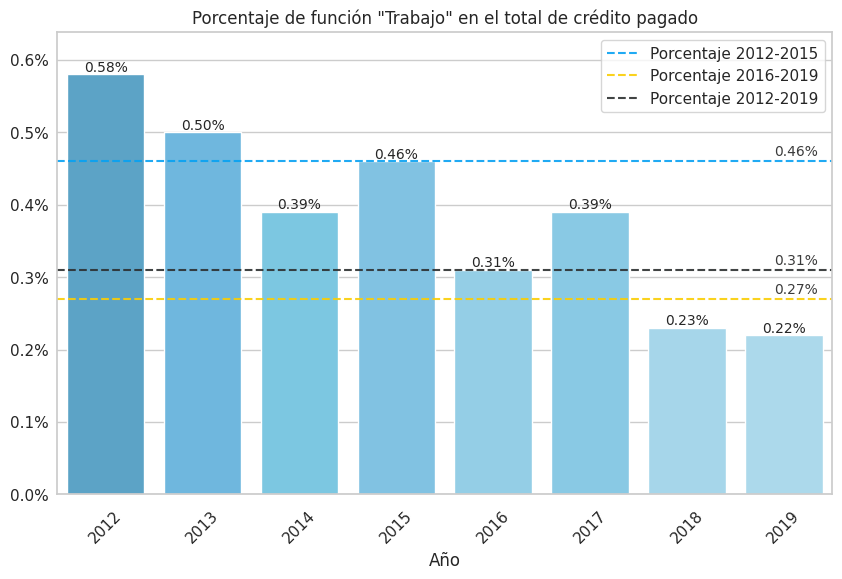

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Datos
años = list(porcentaje_por_año.keys())
porcentajes = list(porcentaje_por_año.values())
periodos = list(porcentaje_por_periodo.keys())
porcentajes_periodos = list(porcentaje_por_periodo.values())

# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
palette = ['#4aa9d8', '#5dbdf0', '#6bcff2', '#71c8f2', '#86d4f4', '#7acff3', '#9bdbf5', '#a2ddf5']
ax = sns.barplot(x=años, y=porcentajes, hue=años , legend=False, palette=palette)

# Configuración de etiquetas y título
ax.set_xlabel('Año')
ax.set_title('Porcentaje de función "Trabajo" en el total de crédito pagado')
ax.set_xticks(range(len(años)))
ax.set_ylim(0, max(porcentajes) * 1.1)
ax.set_xticklabels(años, rotation=45)

# Formatear el eje y como porcentaje
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
ax.yaxis.set_tick_params(pad=0.05)

# Etiquetas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

# Líneas punteadas para los períodos
colores = ['#07a1f2', '#facd05', '#2c2f30']
for i in range(len(periodos)):
    plt.axhline(porcentajes_periodos[i], color=colores[i], linestyle='--',
                linewidth=1.5, label=f'Porcentaje {periodos[i]}', alpha=0.9)
    plt.text(len(años) - 1.1, porcentajes_periodos[i] + 0.008, f'{porcentajes_periodos[i]}%', fontsize=10, alpha=0.9)

# Añadir leyenda
plt.legend()

# Guardar y mostrar el gráfico
plt.savefig('plots/presupuesto/pagos_funcion_trabajo.png', bbox_inches='tight')
plt.show()